# Beginner Tutorial - Part 2

## Introduction

Part 2 of the Beginner Tutorial builds on the concepts covered in Part 1 to demonstrate a slightly more complex model. In contrast to Part 1, Part 2 uses:

* A dataset of real human similarity judgments that were made while viewing images of birds.
* A multi-output model that makes predictions for two different trial configurations.

The tutorial is divided into five parts:

1. Problem Formulation
2. Data Preparation
3. Model Construction
4. Model Inference
5. Model Analysis

If you would like to run this notebook on your local machine, the file is available at [PsiZ's GitHub](https://github.com/psiz-org/psiz/blob/main/docs/src/tutorials/beginner_tutorial_part2.ipynb).

### Preliminaries

Start by importing packages and setting some environment variables.

```{note}
If you want to force execution to use a specific GPU, you can uncomment the lines marked with an `A`. If uncommented, the current setting will force execution to use "GPU 0". If you want to force *eager execution*, uncomment the line marked with a `B`. Eager execution is useful for debugging since it uses a non-optimized CPU mode that allows line-by-line state inspection. See the [TensorFlow Guide](https://www.tensorflow.org/guide/effective_tf2#debugging) for more information.
```

In [17]:

import itertools
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from scipy.stats import pearsonr
import tensorflow as tf
import tensorflow_probability as tfp

import psiz

# Optional settings, see Note for explanation.
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # A
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # A
# tf.config.run_functions_eagerly(True)  # B


```{note}
If you want to force execution to use a specific GPU, you can uncomment the lines marked with an `A`. If uncommented, the current setting will force execution to use "GPU 0". If you want to force *eager execution*, uncomment the line marked with a `B`. Eager execution is useful for debugging since it uses a non-optimized CPU mode that allows line-by-line state inspection. See the [TensorFlow Guide](https://www.tensorflow.org/guide/effective_tf2#debugging) for more information.
```

We also install PsiZ Datasets (`psiz-datasets`) if it is not already in the Jupyter kernel. PsiZ Datasets builds on TensorFlow Datasets (`tensorflow-datasets`) to hosts a select number of PsiZ-ingestable datasets. We will use Psiz Datasets to load the dataset needed for this tutorial.

In [18]:

import sys
!{sys.executable} -m pip install -q psiz-datasets

import tensorflow_datasets as tfds
import psiz_datasets.birds16_rank2019


[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: pip install --upgrade pip


## Problem Formulation

Imagine we are interested in understanding how the average person perceives a set of **208 bird images** ({numref}`fig-birds-16-thumbs`). This means we would like to answer questions like the following:

1. How do different species cluster in psychological space?
2. Which bird images are prototypical of their species?
3. Which species have the largest feature variability? 
4. What perceptual features are the most salient?
5. What perceptual features are ignored?

```{figure} ../../img/birds-16_thumbs.png
---
align: center
name: fig-birds-16-thumbs
alt: "A 13-by-12 grid of thumbnail images."
---
All images in the birds-16 dataset. Each column depicts a single species.
```

Birds provide an informative testbed for psychological research because *within-species* variability can be as large as *across-species* variability. When researchers can confidently answer questions like the ones above for birds, it means we can also answer similar questions about other domains---such as understanding how medical professionals recognize which skin lesions are life threatening. A general approach to understanding human perception helps scientists and policy makers to design strategies and interventions that help society. Once you know how something works, you can start to improve it. For example, medical training programs might be made more efficient and less effortful.

### Solving with Psiz

As covered in the Beginner Tutorial - Part 1, PsiZ uses statistical inference to understand people's mental representations. It is useful to think of a PsiZ model as having three conceptual components: a *percept* module, a *proximity* module, and a *behavior* module.

### Choosing a Task

We will leverage an existing dataset that uses a generalization of the triplet similarity task. The generalization includes triplet trials as a special case. In addition to trials that show three images, some trials show a grid of nine images ({numref}`fig-bird-trial-display`). Like the triplet case, the center image is called the *query* and the surrounding images are called *references*. Instead of selecting just one reference image, the task is to select the **two reference** images that are most similar to the query. In addition, participants rank their selections. Completing one of these displays constitutes one *8-rank-2 similarity judgment*. From this perspective, a traditional triplet trial could be called a *2-rank-1 similarity judgment*.

```{figure} ../../img/bird_trial_display.gif
---
align: center
name: fig-bird-trial-display
alt: Animated GIF showing how participants select reference images given a query image.
---
Recording of B.D.R. completing two ranked 8-rank-2 similarity trials.
```

The advantage of the more complex trials is that additional information can be collected without requiring much additional time from the participant, reducing costs associated with data collection. Loosely speaking, a ranked 8-rank-2 trial contains a similar amount of information as 13 traditional 2-rank-1 trials. To see why, consider a 2-rank-1 trial with query stimulus $q$ and reference stimuli $a$ and $b$. If a participant selects $a$ as more similar, we can use a shorthand to denote the outcome of this trial $q: a > b$. In an 8-rank-2 scenario, there are eight references ($a$-$h$). If a participant selects $a$ as the most similar and $b$ as the second most similar, this implies the following 13 triplet relations:

```{eval-rst}
.. hlist::
   :columns: 3

   * :math:`q: a > b`
   * :math:`q: a > c`
   * :math:`q: a > d`
   * :math:`q: a > e`
   * :math:`q: a > f`
   * :math:`q: a > g`
   * :math:`q: a > h`
   * :math:`q: b > c`
   * :math:`q: b > d`
   * :math:`q: b > e`
   * :math:`q: b > f`
   * :math:`q: b > g`
   * :math:`q: b > h`
```

The implied triplet contraints form the basis for inferring a multidimensional representation of how people perceive the stimuli ({numref}`fig-bird-embedding-3d`). 

```{figure} ../../img/birds-16_emb_3d.gif
---
align: center
name: fig-bird-embedding-3d
alt: Animated GIF showing a 3D embedding of how people perceive images of birds. The embedding shows that people tend to percieve birds of the same species and family as more similar that images of birds from different species and families.
---
A 3D psychological embedding of bird images derived from human responses. Each dot represents one image and is color-coded based on species membership. The plot shows how bird images of the same species tend to cluster close together. On a larger scale, bird images belonging to the same taxonomic family also tend to cluster together.
```

### Model Hyperparameters

For this tutorial, we will infer a **two-dimensional embedding** in order to keep the model simple and facilitate later visualization.

## Data Preparation

We start by loading our data as a TensorFlow `Dataset` using PsiZ Datasets (`psiz-datasets`). The first time you load the `birds16_rank2019` dataset, it will be automatically downloaded to your local machine. Note that the loader knows where to find this dataset because of our previous import `import psiz_datasets.birds16_rank2019`

In [19]:
tfds_all, info = tfds.load(
    'birds16_rank2019/without_timestep', split='train', with_info=True
)

The loaded dataset is a previously collected set of ranked similarity judgments {cite}`Roads_Mozer_2019_BRM,Roads_Mozer_2021_NECO`. The judgments were collected while participants viewed displays containing bird images. The bird images are derived from the CUB200 bird dataset {cite}`Wah_etal_CUB200_2011`.

Since we will not be creating a sequence-sensitive model, we request a version of the dataset without timesteps (i.e., the timestep axis is combined with the sample axis).


### Stimulus Metadata

When we load the dataset and set the optional argument `with_info=True`, we gain access to important metadata regarding the stimuli.

In [20]:
df_stimuli = pd.DataFrame.from_dict(info.metadata['stimuli'], orient='index')

n_stimuli = len(df_stimuli)
print('Number of Stimuli: {}'.format(n_stimuli))
df_stimuli.head()

Number of Stimuli: 208


,filepath,common_name,taxonomic_family
1,birds_16/Cardinalidae/Blue_Grosbeak/Blue_Grosb...,Blue Grosbeak,Cardinalidae
2,birds_16/Cardinalidae/Blue_Grosbeak/Blue_Grosb...,Blue Grosbeak,Cardinalidae
3,birds_16/Cardinalidae/Blue_Grosbeak/Blue_Grosb...,Blue Grosbeak,Cardinalidae
4,birds_16/Cardinalidae/Blue_Grosbeak/Blue_Grosb...,Blue Grosbeak,Cardinalidae
5,birds_16/Cardinalidae/Blue_Grosbeak/Blue_Grosb...,Blue Grosbeak,Cardinalidae


The stimulus metadata is arranged such that each stimulus has an ID that maps to additional information (stimulus filename, common species name, taxonomic family). If you need to convert a stimulus ID to a filepath, you can use the provided metadata. The stimulus IDs are used by the loaded Dataset and will correspond to the embedding index used in the models.

```{note}
You may have noticed that the stimulus IDs begin at `1`, not `0`. This is intentional because `0` is reserved for masking.
```

### Dataset Samples

Next, we can take a look inside the `Dataset` object. First we will format the dataset as an (input, target, sample weight) tuple, ignoring some features that we do not need (e.g., agent IDs, response times). If you recall, it was mentioned earlier that we will be using a dataset composed of two *trial configurations*: 2-rank-1 and 8-rank-2 trials. Therefore we create separate fields for both trial configurations.

```{note}
When structuring data for a multi-output model, the dictionary keys tells the TensorFlow training routine which model outputs, targets, sample weights, and losses go together. You will notice we use `given2rank1_outcome` and `given8rank2_outcome` consistently to connect these different pieces. Check out the [TensorFlow Guide](https://www.tensorflow.org/guide/keras/functional#models_with_multiple_inputs_and_outputs) or the [Keras Guide](https://keras.io/guides/functional_api/) for more information on building multi-output models.
```

In [21]:
def format_data_for_training(sample):
    """Format sample as (x, y, w) tuple."""
    x = {
        'given2rank1_stimulus_set': sample['given2rank1_stimulus_set'],
        'given8rank2_stimulus_set': sample['given8rank2_stimulus_set'],
    }
    y = {
        'given2rank1_outcome': sample['given2rank1_outcome'],
        'given8rank2_outcome': sample['given8rank2_outcome'],
    }
    w = {
        'given2rank1_outcome': sample['given2rank1_sample_weight'],
        'given8rank2_outcome': sample['given8rank2_sample_weight'],
    }
    return (x, y, w)

tfds_all = tfds_all.map(
    lambda sample: format_data_for_training(sample)
)

# Count number of samples in dataset.
n_sample = 0
for _ in tfds_all:
    n_sample += 1

print('Number of samples (i.e., trials): {}'.format(n_sample))

Number of samples (i.e., trials): 18245



The first sample is an 8-rank-2 trial.

In [22]:
first_sample = list(tfds_all.take(1).as_numpy_iterator())[0]
print(
    'First Sample\n'
    '  2-rank-1 stimulus IDs: {}\n'
    '  2-rank-1 outcome: {}\n'
    '  2-rank-1 sample weight: {}\n\n'
    '  8-rank-2 stimulus IDs: {}\n'
    '  8-rank-2 outcome: {}\n'
    '  8-rank-2 sample weight: {}\n'.format(
        first_sample[0]['given2rank1_stimulus_set'],
        first_sample[1]['given2rank1_outcome'],
        first_sample[2]['given2rank1_outcome'],
        first_sample[0]['given8rank2_stimulus_set'],
        first_sample[1]['given8rank2_outcome'],
        first_sample[2]['given8rank2_outcome'],
    )
)

First Sample
  2-rank-1 stimulus IDs: [0 0 0]
  2-rank-1 outcome: [1. 0.]
  2-rank-1 sample weight: 0.0

  8-rank-2 stimulus IDs: [ 59  85 143 167 171 194 117 201 146]
  8-rank-2 outcome: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
  8-rank-2 sample weight: 1.0



There a few points worth emphasizing:
1. Instead of storing stimuli filenames in the `Dataset` object, we store stimulus IDs, which are also used as indices into an embedding layer. Since each trial is composed of a set of stimuli, we name this attribute `stimulus_set`.
2. The stimuli indices for each trial are stored following a convention ({numref}`fig_8-rank-2_label_convention`). The convention is best explained using abstract notation. In the 8-rank-2 case, we use the following notation: query stimulus ($q$), first chosen reference ($a$), second chosen reference ($b$), and all remaining unchosen references ($c$-$h$). The convention stipulates that the $i$th observed trial is recorded using the array format $\mathcal{D}_{i}=\left[q, a, b, c, d, e, f, g, h\right]$. All trials are then stacked to create a complete set of observed data $\mathcal{D}$. The convention is similar for 2-rank-1 trials; $\mathcal{D}_{i}=\left[q, a, b\right]$, where $a$ is the selected reference and $b$ is the unselected reference. In the 2-rank-1 case, a *mask value* of `0` is used to pad out the "unused" references.
3. The model architecture assumes that 2-rank-1 **and** 8-rank-2 inputs are provided for every sample, but only one (non-placeholder) configuration will actually be provided per sample. We use a sample weight of `0.0` to tell the model to ignore the output of a particular trial. To promote readability, we also use a stimulus index of `0` to flag a placeholder stimulus.

```{figure} ../../img/n-choose-k_label_convention.png
---
align: center
name: fig_8-rank-2_label_convention
alt: Diagram showing labeling convention of stimuli.
---
Example demonstrating how a single 2-rank-1 and 8-rank-2 similarity trial are recorded. Instead of showing actual images, abstract boxes are used to denote a stimuli. The color of the box indicates wether a stimulus is a query (yellow), selected reference (blue), or unselected reference (gray). 
```

```{warning}
After printing out the stimuli indices, you can see why the stimuli indices started at `1`. The index `0` is used as a special placeholder or *mask value*. When we build our model, we will make sure to let the model know that `0` should be interpretted as a mask by passing `mask_zero=True` as an argument. In general, you can use data and build models that do not use masking; but many situations---such as using multiple trial configurations---require masking.
```

### Partition the Dataset

In general, when fitting a model we are primarily intersted in how well a model generalizes to **new** data and therefore want to prevent overfitting. To achive this goal we follow standard practice and partition the data into a train, validation, and test set. In this tutorial we use an 80:10:10 split.

In [23]:
# Set the batch_size.
batch_size = 128

# Partition the data into 80% train, 10% validation and 10% test set.
n_sample_train = int(np.floor(0.8 * n_sample))
n_sample_val = int(np.floor(0.1 * n_sample))

# Shuffle data before partioning
tfds_all = tfds_all.shuffle(buffer_size=n_sample)

tfds_train = tfds_all.take(n_sample_train).cache().shuffle(
    buffer_size=n_sample_train, reshuffle_each_iteration=True
).batch(batch_size, drop_remainder=False)
tfds_valtest = tfds_all.skip(n_sample_train)
tfds_val = tfds_valtest.take(n_sample_val).cache().batch(
    batch_size, drop_remainder=False
)
tfds_test = tfds_valtest.skip(n_sample_val).cache().batch(
    batch_size, drop_remainder=False
)

With our data ready, we can move on to constructing our model.

## Model Construction

Our modelling approach will be very similar that used in the Beginner Tutorial - Part 1. The only meaningful difference is that we will create two behavior modules; one handling 2-rank-1 similarity judgments and the other handling 8-rank-2 similarity judgments. As in Part 1, we will ignore agent information (i.e., individual differences) and create a population-level model.

### Percept Module

The percept module is a single embedding layer configured based on the number of stimuli in our dataset.

```
percept = tf.keras.layers.Embedding(
    n_stimuli + 1,
    n_dim,
    mask_zero=True,
    embeddings_initializer=tf.keras.initializers.RandomNormal(stddev=.17, seed=seed)
)
```

### Proximity Module

The proximity module is identical to the one used in the Beginner Tutorial - Part 1.

```
proximity = psiz.keras.layers.Minkowski(
    rho_initializer=tf.keras.initializers.Constant(2.),
    w_initializer=tf.keras.initializers.Constant(1.),
    activation=psiz.keras.layers.ExponentialSimilarity(
        beta_initializer=tf.keras.initializers.Constant(10.),
        tau_initializer=tf.keras.initializers.Constant(1.),
        gamma_initializer=tf.keras.initializers.Constant(0.),
        trainable=False,
    ),
    trainable=False
)
```

### Behavior Module

In this tutorial, we will create two behavior modules, one for each trial configuration. While this tutorial is combining data from different rank similarity *configurations*, one could also create behavior modules for completely different tasks (.e.g., similarity ratings on a 5-point scale, odd-one-out similarity judgments and similarity rankings). The behavioral outcomes of a 2-rank-1 trial and an 8-rank-2 trial are both computed using a `SoftRank` layer, but configured for a different number of selections (`n_select`).

```
soft_2rank1 = psiz.keras.layers.SoftRank(n_select=1)

soft_8rank2 = psiz.keras.layers.SoftRank(n_select=2)
```

As a reminder, 2-rank-1 outcomes are compute using Luce's choice rule {cite}`Luce_1959`. This means that a reference is selected in proportion to its similarity with the query. The probability of selecting reference `a` instead of reference `b` is: 
```{math}
:label: eq:part2_2-rank-1
\mathrm{P} \left( \mathcal{D}_{i} = \left[q, a, b \right] \right) = \frac{\mathrm{s} \left( \bm{z}_q, \bm{z}_a \right)}{\mathrm{s} \left( \bm{z}_q, \bm{z}_a \right) + \mathrm{s} \left( \bm{z}_q, \bm{z}_b \right)}.
```

The 8-rank-2 case is slightly more complicated since there are more references and there are two sequential selections. More references are easily handled by switching to summation notation. Multiple selections are handled by recognizing a sequence of events is expressed as a product of the individual events: 
```{math}
:label: eq:8-rank-2-b
\mathrm{P} \left( \mathcal{D}_{i} = \left[q, a, b, c, d, e, f, g, h \right] \right) = \frac{\mathrm{s} \left( \bm{z}_q, \bm{z}_a \right)}{\sum_{i \in 
 \{a-h\}} \mathrm{s} \left( \bm{z}_q, \bm{z}_i \right)} \frac{\mathrm{s} \left( \bm{z}_q, \bm{z}_b \right)}{ \sum_{j \in \{b-h\}} \mathrm{s} \left( \bm{z}_q, \bm{z}_j \right)}.
```

Using these equations you can compute the probabilities associated with all possible outcomes. For a 2-rank-1 trial there are two possible outcomes. for a 8-rank-2 trial there are 56 possible outcomes. If one needs to run a model in generative mode, these probabilties can be converted to a single outcome by sampling from the corresponding distribution.

### Putting it All Together

The last step is to package all of these pieces up inside a Keras `Model`. To handle different trial configurations, we create a multi-output model. For convenience, the construction code is wrapped by a `build_rank_model` function.

In [24]:
class RankModel(tf.keras.Model):
    """A Keras model of ranked similarity judgments."""

    def __init__(self, percept=None, proximity=None, **kwargs):
        """Initialize."""
        super(RankModel, self).__init__(**kwargs)
        self.stimuli_axis = 1

        self.percept = percept
        self.proximity = proximity

        # Create the behavior modules.
        self.soft_2rank1 = psiz.keras.layers.SoftRank(n_select=1)
        self.soft_8rank2 = psiz.keras.layers.SoftRank(n_select=2)

    def call(self, inputs, training=None):
        """Call."""
        # The 2-rank-1 branch.
        z = self.percept(inputs["given2rank1_stimulus_set"])
        z_q, z_r = tf.split(z, [1, 2], self.stimuli_axis)
        s = self.proximity([z_q, z_r])
        prob_2rank1 = self.soft_2rank1(s)

        # The 8-rank-2 branch.
        z = self.percept(inputs["given8rank2_stimulus_set"])
        z_q, z_r = tf.split(z, [1, 8], self.stimuli_axis)
        s = self.proximity([z_q, z_r])
        prob_8rank2 = self.soft_8rank2(s)

        outputs = {
            "given2rank1_outcome": prob_2rank1,
            "given8rank2_outcome": prob_8rank2
        }
        return outputs

    def get_config(self):
        config = super(RankModel, self).get_config()
        return config


def build_model(n_stimuli, n_dim, seed=None):
    """Build population-level, MLE, rank similarity model.

    Args:
        n_stimuli: Integer indicating the number of stimuli in the
            embedding.
        n_dim: Integer indicating the dimensionality of the embedding.
        seed (optional): Integer that controls initialization of
            embedding layer.

    Returns:
        model: A compiled Keras model.

    """
    # Create an `Embedding` layer that contains free parameters representing
    # the psychological coordinates of the stimuli.
    percept = tf.keras.layers.Embedding(
        n_stimuli + 1, n_dim, mask_zero=True,
        embeddings_initializer=tf.keras.initializers.RandomUniform(
            seed=seed
        )
    )

    # Create a proximity function layer that computes the similarity between
    # coordinates in psychological space.
    proximity = psiz.keras.layers.Minkowski(
        rho_initializer=tf.keras.initializers.Constant(2.),
        w_initializer=tf.keras.initializers.Constant(1.),
        activation=psiz.keras.layers.ExponentialSimilarity(
            beta_initializer=tf.keras.initializers.Constant(10.),
            tau_initializer=tf.keras.initializers.Constant(1.),
            gamma_initializer=tf.keras.initializers.Constant(0.),
            trainable=False,
        ),
        trainable=False
    )
    
    # Pass component layers to a subclassed model.
    model = RankModel(percept=percept, proximity=proximity)

    # Compile the model using categorical crossentropy for the loss and
    # a popular gradient decent optimizer.
    model.compile(
        loss={
            'given2rank1_outcome': tf.keras.losses.CategoricalCrossentropy(
                name='given2rank1_loss'
            ),
            'given8rank2_outcome': tf.keras.losses.CategoricalCrossentropy(
                name='given8rank2_loss'
            ),
        },
        weighted_metrics={
            'given2rank1_outcome': tf.keras.metrics.CategoricalCrossentropy(
                name='given2rank1_cce'
            ),
            'given8rank2_outcome': tf.keras.metrics.CategoricalCrossentropy(
                name='given8rank2_cce'
            ),
        },
        optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
    )

    return model

Note that the model's `call` method returns a dictionary containing the two different outputs. Since we have created a multi-output model, our compile method needs to specify the loss for each branch. In our case, we want to use categorical cross-entropy for both branches. The dictionary keys returned by the call method must match those used in the compile method.

Also notice that we are using the same `percept` and `proximity` module for both trial configurations. In other words, this model assumes that people use the same perceptual and similarity process for both 2-rank-1 and 8-rank-2 trials. If necessary, one could use different percept and proximity modules for each trial configuration.

## Model Inference

For this tutorial we will infer a two-dimensional embedding since our primary goal is to obtain a convenient visualization. When inferring an embedding that is meant to serve as more than a visualization, it is important to select the dimensionality in a principled manner (e.g., via cross-validation).

We will create two models with identical architectures but different weight initializations in order to address three questions:
1. How do different initializations impact the inferred solutions?
2. How do we compare different solutions?
2. How do we know when sufficient data has been collected?

In [25]:
# Set the number of dimensions for the embedding.
n_dim = 2

# Instantiate two models using two different random number generator seeds.
model_0 = build_model(n_stimuli, n_dim, seed=0)
model_1 = build_model(n_stimuli, n_dim, seed=3)

We will train our models until validation loss stops improving. The number of epochs (`epochs`) is set to a sufficiently high number that the model reaches the early stopping criteria before the maximum number of epochs is exceeded.

```{note}
Inference can take a few minutes to run depending on your hardware setup.
```

In [26]:
def train_routine(model, tfds_train, tfds_val, tfds_test):
    """Run training routine.
    
    Args:
        model: A PsiZ model.
        tfds_train: A TF Dataset object of train data.
        tfds_val: A TF Dataset object of validation data.
        tfds_test: A TF Dataset object of test data.

    Returns:
        metrics: A dictionary of metrics.

    """
    epochs = 3000  # NOTE: This is overkill, but early stopping will kick in.

    # Define an early stopping callback.
    early_stop = tf.keras.callbacks.EarlyStopping(
        'val_loss', patience=30, mode='min', restore_best_weights=True
    )
    callbacks = [early_stop]

    # Fit model.
    model.fit(
        x=tfds_train,
        validation_data=tfds_val,
        epochs=epochs,
        callbacks=callbacks,
        verbose=0
    )

    # Evaluate model.
    train_metrics = model.evaluate(tfds_train, verbose=0, return_dict=True)
    val_metrics = model.evaluate(tfds_val, verbose=0, return_dict=True)
    test_metrics = model.evaluate(tfds_test, verbose=0, return_dict=True)

    print(
        'Metrics\n'
        '    train_loss: {0:.3f}\n'
        '    val_loss: {1:.3f}\n'
        '    test_loss: {2:.3f}\n'.format(
            train_metrics['loss'],
            val_metrics['loss'],
            test_metrics['loss']
        )
    )
    metrics = {
        'train': train_metrics,
        'val': val_metrics,
        'test': test_metrics,
    }
    return metrics


print('Model 0')
metrics_0 = train_routine(model_0, tfds_train, tfds_val, tfds_test)

print('Model 1')
metrics_1 = train_routine(model_1, tfds_train, tfds_val, tfds_test)

Model 0
Metrics
    train_loss: 1.532
    val_loss: 1.589
    test_loss: 1.549

Model 1
Metrics
    train_loss: 1.531
    val_loss: 1.590
    test_loss: 1.548



After reaching the early stopping criteria, we can see that the two models have similar---but not identical---train, validation, and test losses.

We still need to answer a few questions:
1. Are the results sensible?
2. Are the models being trained with a sufficient amount of data?

## Model Analysis

We can conduct a similar analysis to that used in Beginner Tutorial - Part 1. We will start by visualizing the embeddings wholistically and then create visualizations for each taxonomic family. Since the similarity judgments are derived from a real image dataset, we can make some colorful tweaks to our embedding visualizations. Second, we will conduct a similarity analysis to assess model convergence.

### Embedding Visualization

Since we intentionally chose to create 2D embeddings, it is straightforward to create visualizations of the infeerred embeddings. We will color code each stimulus based on it's species membership and use a different marker shape for each of the four taxonomic bird families. Given what we know about the visual features of the image dataset, we expect a sensible solution to show stimuli from the same species to cluster close together and we expect species from the same family to cluster close together.

Let's start by defining a unique color for each bird species and a unique marker for each taxonomic family. We'll use this styling for all of the visualizations.

In [27]:
def bird_class_styling(df_stimuli):
    """Hard-coded styling for bird classes.
    
    This function assumes it is creating class stylings for the
    birds-16 dataset.

    Args:
        df_stimuli: A Pandas DataFrame of stimuli metadata.

    Returns:
        class_styling: A dictionary of `color` and `marker` arrays; one
            for each class.

    """
    df_species = (
        df_stimuli[["common_name", "taxonomic_family"]]
        .drop_duplicates()
        .sort_values(["taxonomic_family", "common_name"], ignore_index=True)
    )
    n_species = len(df_species)

    # Define one color per species for plots.
    cmap = matplotlib.cm.get_cmap('gist_ncar')
    norm = matplotlib.colors.Normalize(vmin=0., vmax=n_species)
    species_color_arr = cmap(norm(range(n_species)))
    # Permute order so that similar colors are not adjacent.
    species_color_arr = species_color_arr[[
        0, 4, 8, 12, 1, 5, 9, 13, 2, 6, 10, 14, 3, 7, 11, 15
    ]]

    # Use a unique marker for each bird family.
    family_marker_arr = [
        'o', 'o', 'o', 'o',
        'v', 'v', 'v', 'v',
        's', 's', 's', 's',
        '*', '*', '*', '*',
    ]
    
    class_styling = {}
    for idx, row in df_species.iterrows():
        class_styling[row['common_name']] = {
            'marker': family_marker_arr[idx],
            'color': species_color_arr[np.newaxis, idx]
        }
    return class_styling

class_styling = bird_class_styling(df_stimuli)

With our styling defined, we can create a visualization for each model.

[]

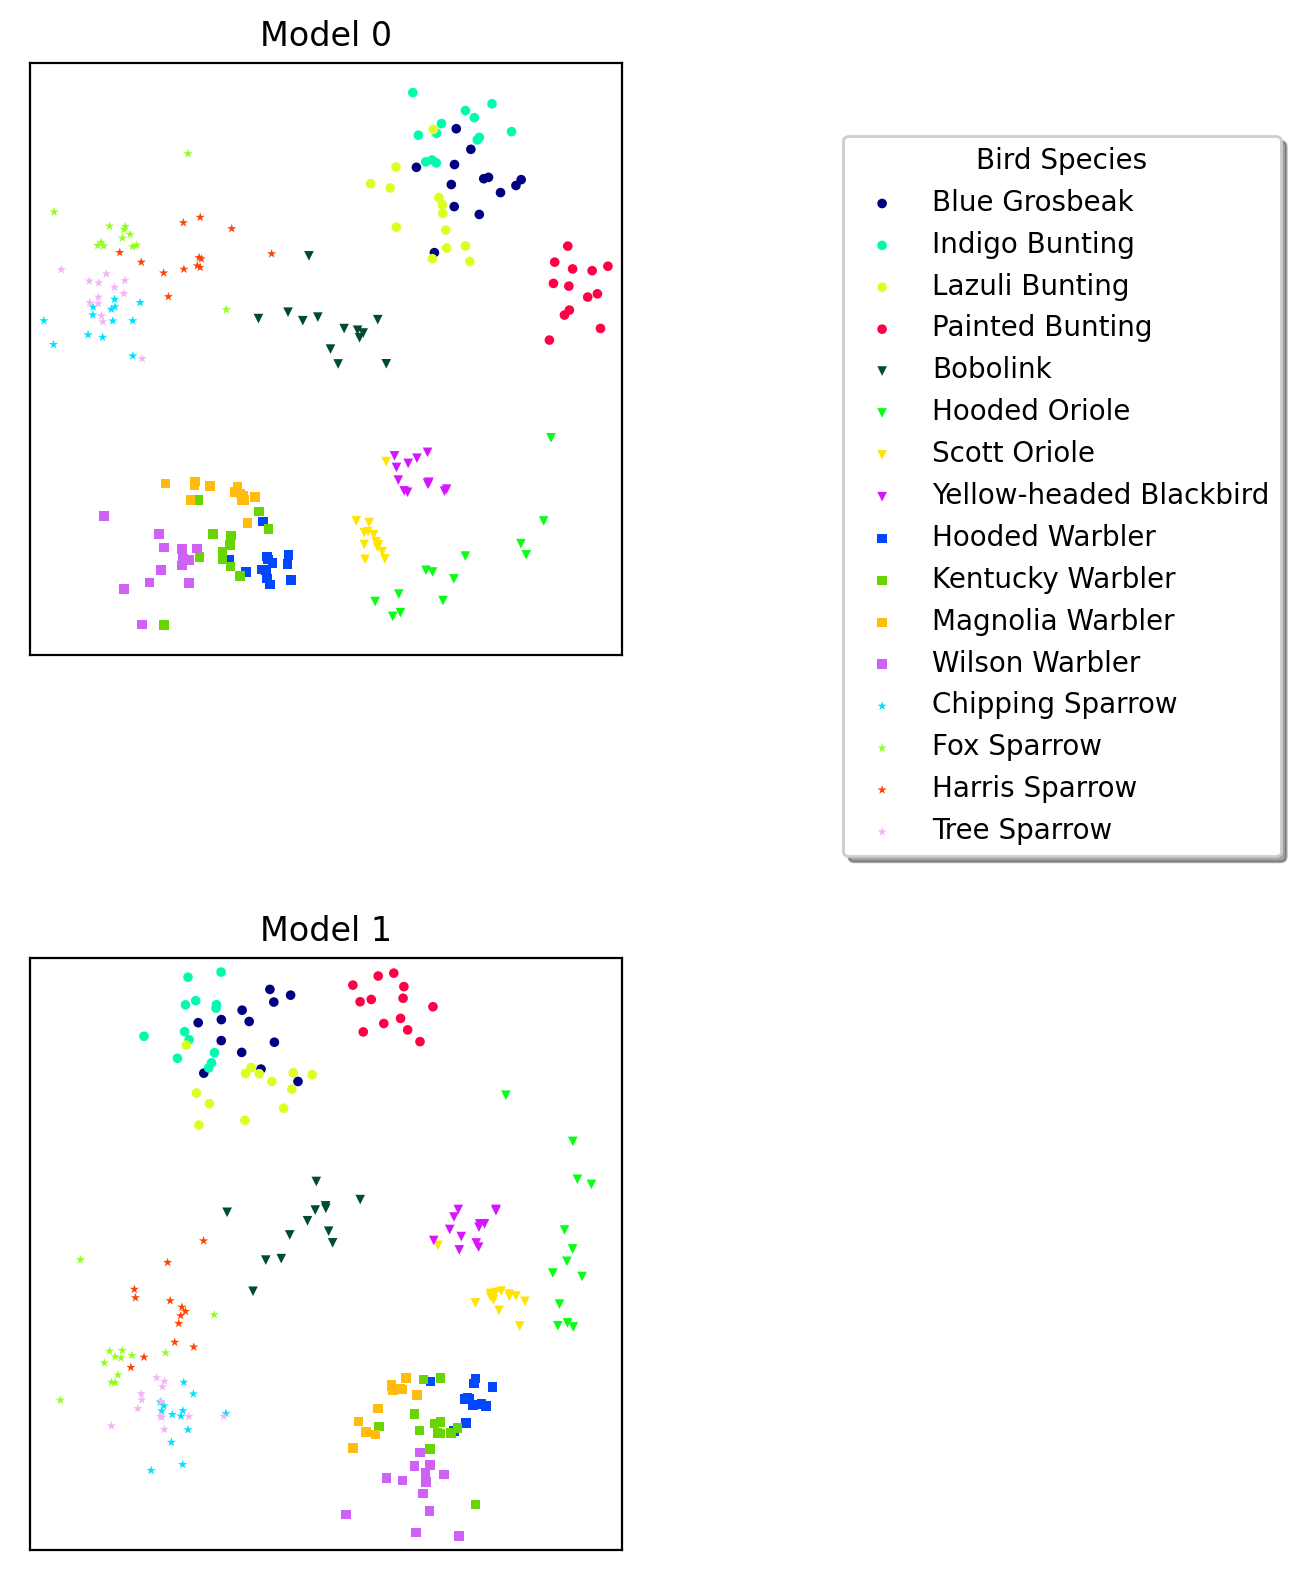

In [28]:
def plot_embedding(ax, model, df_stimuli, class_styling):
    """Plot entire embedding.
    
    Args:
        ax: A Matplotlib axes object.
        model: A PsiZ model.
        df_stimuli: A Pandas DataFrame of stimuli metadata.
        class_styling: A dictionary of style information for each
            class.

    """
    # Hardcoded values.
    s = 12  # Size of plot markers.

    df_species = (
        df_stimuli[["common_name", "taxonomic_family"]]
        .drop_duplicates()
        .sort_values(["taxonomic_family", "common_name"], ignore_index=True)
    )

    # Grab embedding coordinates.
    loc = model.percept.embeddings.numpy()
    if model.percept.mask_zero:
        # Drop placeholder stimulus.
        loc = loc[1:]

    # Center coordinates for prettier plotting.
    loc = loc - np.min(loc, axis=0) - (
        np.max(loc, axis=0) - np.min(loc, axis=0)
    ) / 2

    # Determine embedding limits.
    z_max = 1.05 * np.max(np.abs(loc))
    z_limits = [-z_max, z_max]

    # Draw stimuli modes with exemplars color-coded by species membership.
    # NOTE: We plot each species separately in order to populate the
    # figure legend correctly.
    for index, row in df_species.iterrows():
        common_name = row["common_name"]
        bidx_class = (df_stimuli["common_name"] == common_name).values
        ax.scatter(
            loc[bidx_class, 0], loc[bidx_class, 1], s=s,
            c=class_styling[common_name]['color'],
            marker=class_styling[common_name]['marker'],
            label=common_name,
            edgecolors='none',
            zorder=100,
        )

    ax.set_xlim(z_limits)
    ax.set_ylim(z_limits)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])


# Create visual of `Model 0` and `Model 1`.
fig = plt.figure(figsize=(6.5, 8), dpi=200)
gs = fig.add_gridspec(2, 1)

ax = fig.add_subplot(gs[0, 0])
plot_embedding(ax, model_0, df_stimuli, class_styling)
ax.set_title('Model 0')
ax.legend(bbox_to_anchor=(1.35, 0.9), shadow=True, title="Bird Species")

ax = fig.add_subplot(gs[1, 0])
plot_embedding(ax, model_1, df_stimuli, class_styling)
ax.set_title('Model 1')

gs.tight_layout(fig)
plt.plot()

Let's focus on the visualization for `Model 0` first. We will talk about the differences between the two models after digesting the patterns of `Model 0`. Based on the visualization, embeddings of `Model 0` appear sensible. All families form clear clusters with no family overlap. Both the Buntings and Orioles have an outlier species (Painted Bunting and Bobolink respectively). Within a taxonomic family, the Warblers and Orioles exhibit crisp species sub-clusters. The Buntings and Sparrows exhibit less distinct species sub-clusters, but clearly better than random.

#### Family Embedding Visualizations

To better understand these patterns, we can visualize the actual images alongside the embedding coordinates. Since 208 images is excessive for one plot, we will zoom-in on each family separately. Making these kind of plots look nice and neat involves a bit more work, so the plotting code is more complicated than our first visualization.

```{note}
The images for the bird-16 dataset are hosted on OSF at the `psiz-datasets` repository. A zipped directory of all the birds-16 images can be obtained [here](https://osf.io/x3vuh/). The tutorial code assumes the images are located at `~/.psiz/datasets/birds_16/` and that the dataset directory structure has been unaltered. For example, one of the images would have the filepath `~/.psiz/datasets/birds_16/Cardinalidae/Blue_Grosbeak/Blue_Grosbeak_0002_36648.jpg` If you have placed the image dataset in a different directory update `fp_image_dataset` below.
```

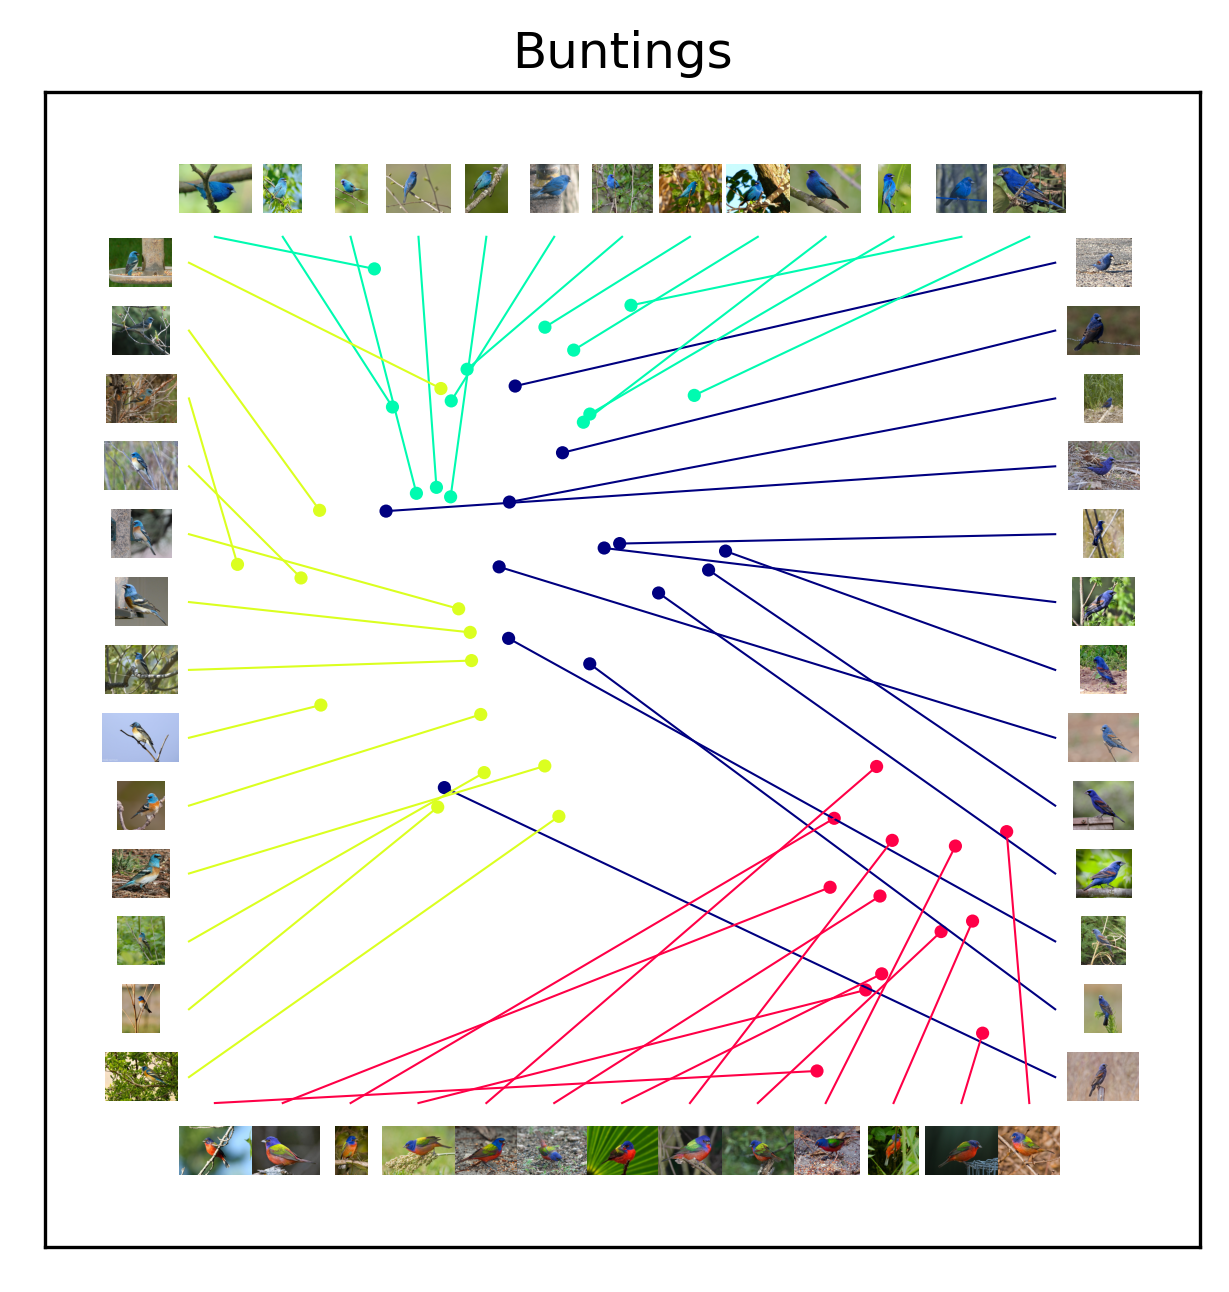

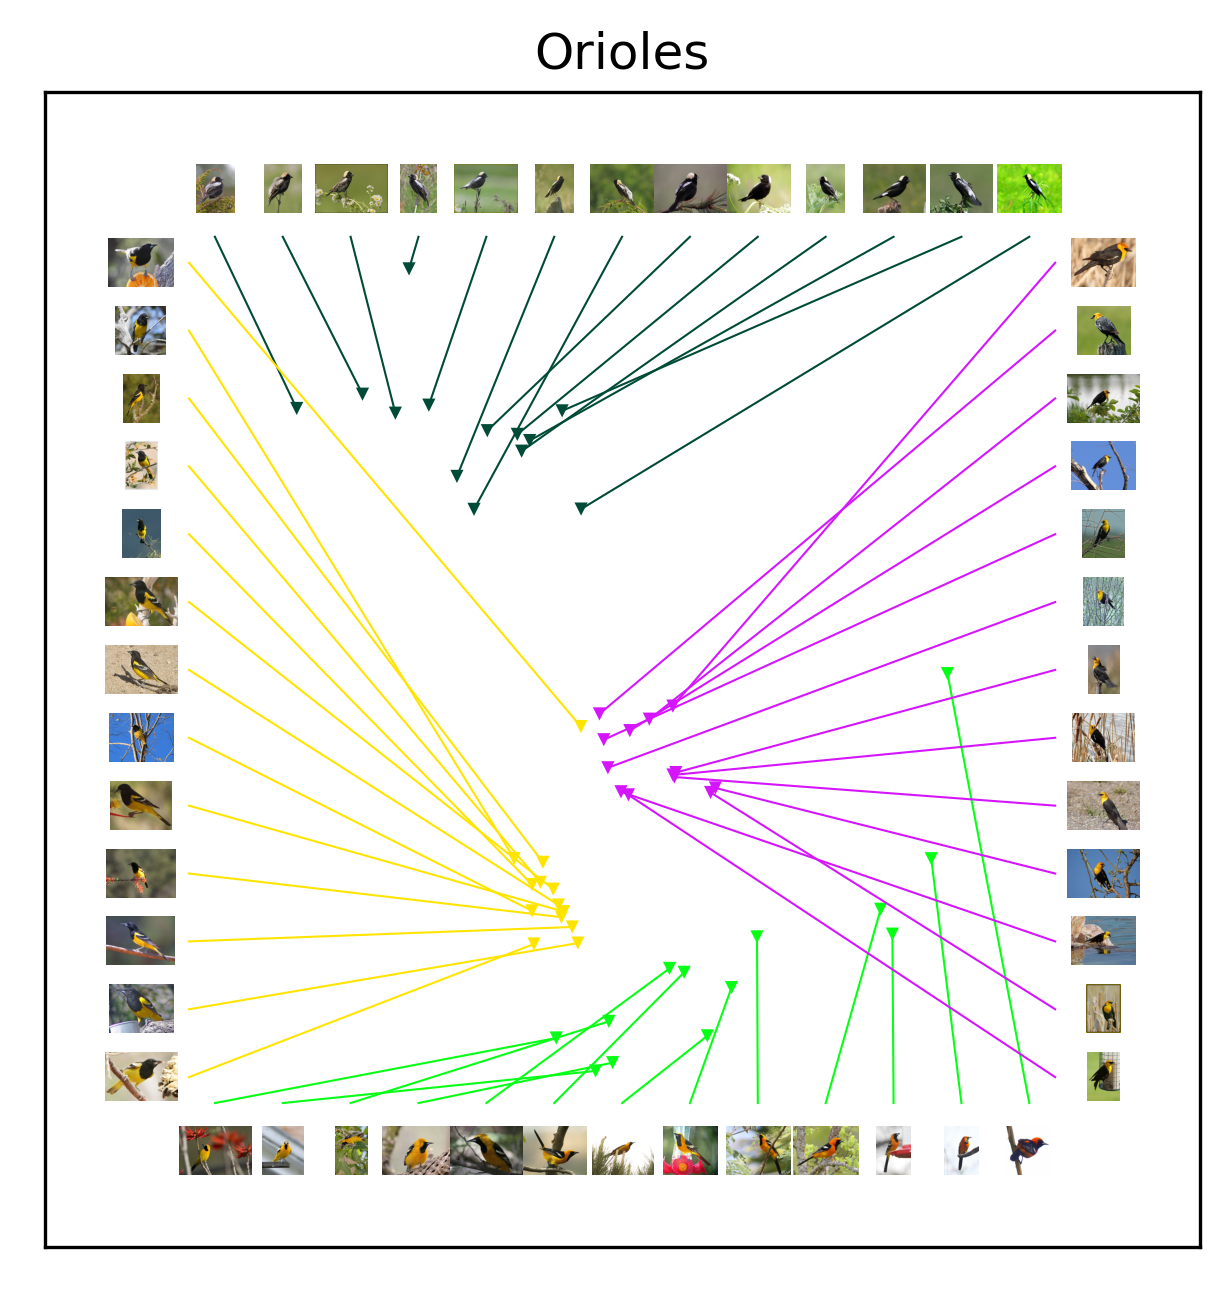

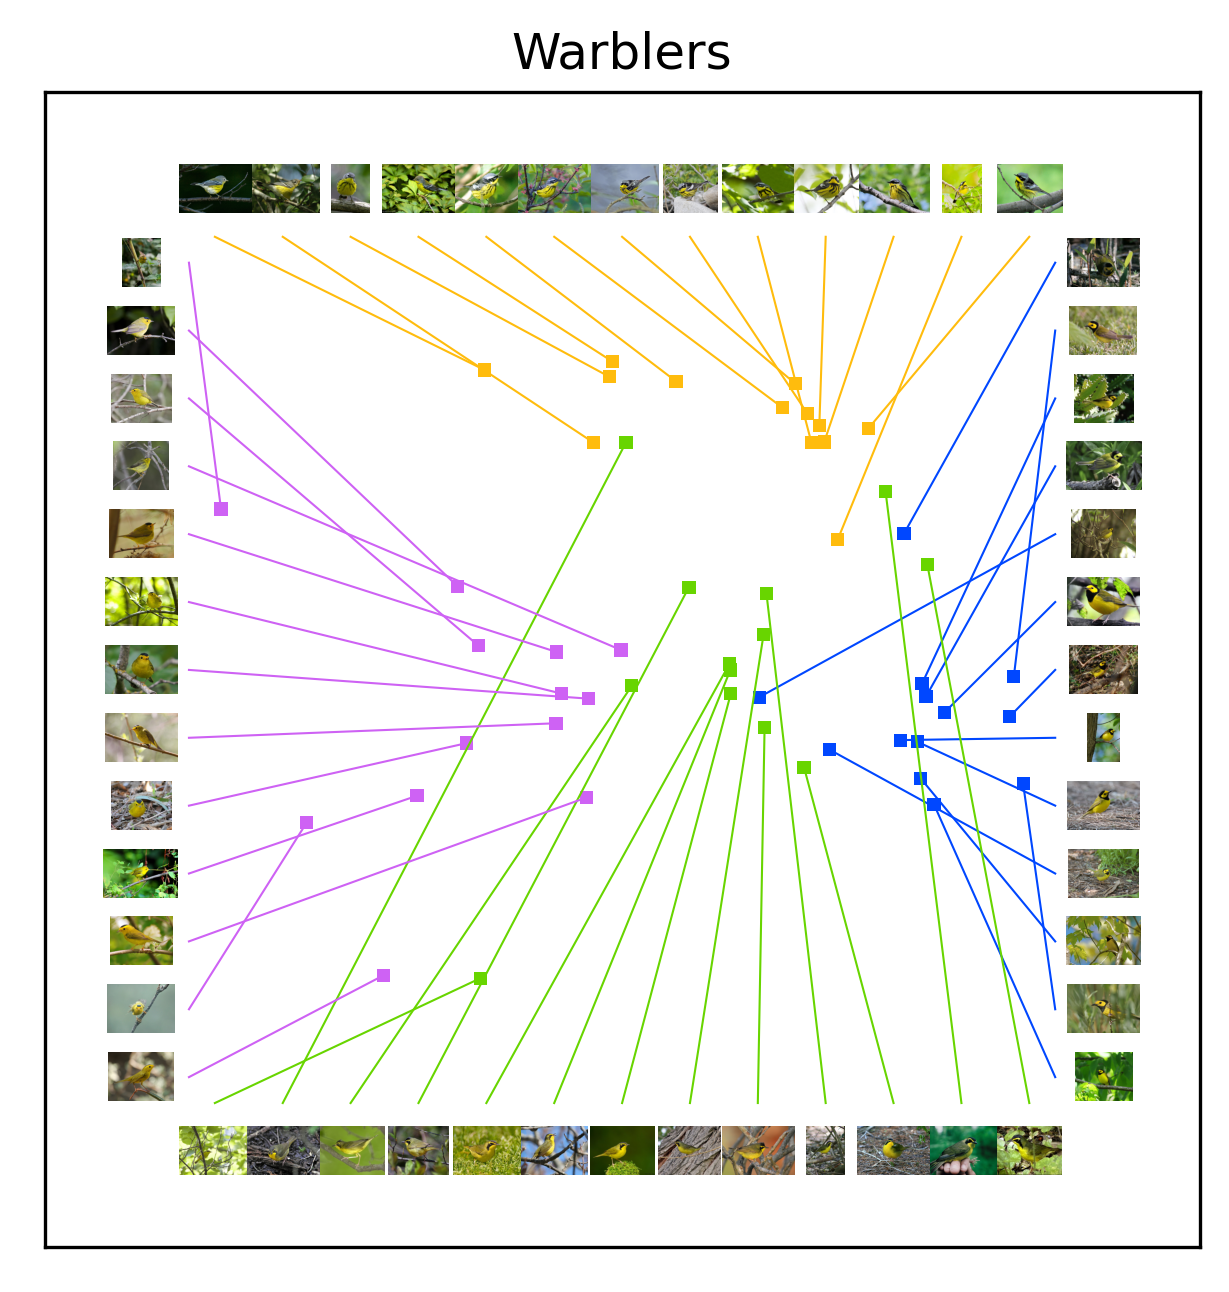

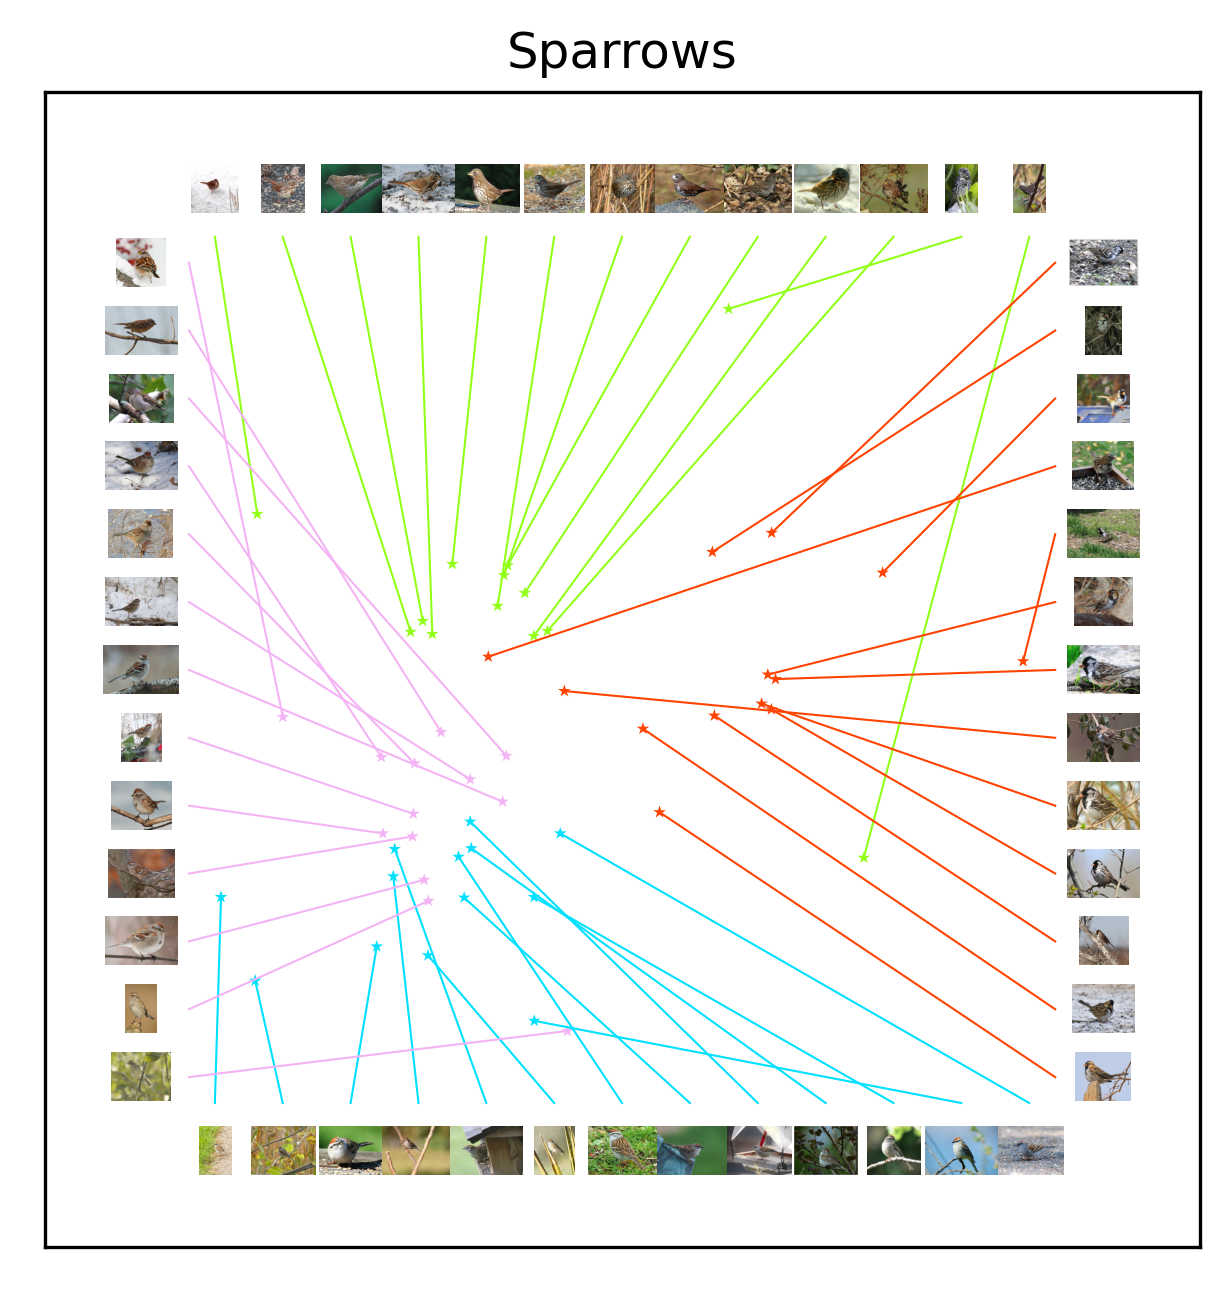

In [29]:
def plot_family(
    model,
    df_stimuli,
    taxonomic_family,
    title_str,
    class_styling,
    fp_image_dataset,
):
    """Plot bird family embedding with images.
    
    Args:
        model: A PsiZ model.
        df_stimuli: A Pandas DataFrame of stimuli metadata.
        taxonomic_family: A string indicating the taxonomic family
            to plot.
        title_str: A string for the plot title.
        class_styling: A dictionary of style information for each
            class.
        fp_image_dataset: Filepath to image dataset.
    """
    # Hardcoded values.
    s = 10  # Size of plot markers.
    scatter_padding = 1.2  # Padding around embedding scatter points.
    image_padding = 1.2  # Additional padding to accomodate border images.

    fig = plt.figure(figsize=(5, 5), dpi=300)
    gs = fig.add_gridspec(1, 1)

    # Select stimuli in the taxonomic family.
    bidx_subset = df_stimuli['taxonomic_family'] == taxonomic_family
    df_stimuli_subset = df_stimuli[bidx_subset].reset_index()
    bidx_subset = bidx_subset.values

    df_family_subset = (
        df_stimuli_subset[["common_name", "taxonomic_family"]]
        .drop_duplicates()
        .sort_values(["taxonomic_family", "common_name"], ignore_index=True)
    )

    # Grab relevant embedding coordinates.
    loc = model.percept.embeddings.numpy()
    if model.percept.mask_zero:
        # Drop placeholder stimulus.
        loc = loc[1:]
    loc = loc[bidx_subset]

    # Center coordinates for prettier plotting.
    loc = loc - np.min(loc, axis=0) - (
        np.max(loc, axis=0) - np.min(loc, axis=0)
    ) / 2
    # Determine embedding limits of family.
    z_max = scatter_padding * np.max(np.abs(loc))
    z_limits = np.array([-z_max, z_max])

    # Draw embedding points.
    ax = fig.add_subplot(gs[0, 0])
    for _, row in df_family_subset.iterrows():
        common_name = row["common_name"]
        bidx_species = (df_stimuli_subset["common_name"] == common_name).values
        ax.scatter(
            loc[bidx_species, 0], loc[bidx_species, 1], s=s,
            c=class_styling[common_name]['color'],
            marker=class_styling[common_name]['marker'],
            label=common_name,
            edgecolors='none'
        )

    ax.set_xlim(image_padding * z_limits)
    ax.set_ylim(image_padding * z_limits)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title_str)

    # Define image coordinates along border of embedding (omit corners).
    border_x = np.hstack([
        np.linspace(1, 12, 13),
        np.zeros(13),
        13 * np.ones(13),
        np.linspace(1, 12, 13),
    ])
    border_y = np.hstack([
        np.zeros(13),
        np.linspace(1, 12, 13),
        np.linspace(1, 12, 13),
        13 * np.ones(13),
    ])
    loc_outer_border = np.stack([border_x, border_y], axis=1)
    # Transform border coordinates into range of embedding coordinates.
    loc_outer_border = ((loc_outer_border / np.max(loc_outer_border)) * (2 * z_max)) - z_max
    
    border_outer_x = np.hstack([
        np.zeros(13),
        np.ones(13),
        np.ones(13),
        np.zeros(13),
    ])
    border_outer_y = np.hstack([
        np.ones(13),
        np.zeros(13),
        np.zeros(13),
        np.ones(13),
    ])
    loc_inner_border = np.stack([border_outer_x, border_outer_y], axis=1)
    loc_inner_border = loc_outer_border - (.1 * loc_inner_border * loc_outer_border)

    # Determine the best border coordinate for each stimulus.
    idx_mapped = solve_mapping(loc, loc_outer_border)
    loc_outer_border = loc_outer_border[idx_mapped]
    loc_inner_border = loc_inner_border[idx_mapped]

    # Set image size based on embedding span.
    image_size = .05 * (2 * z_max)

    # Draw images around border.
    for idx, row in df_stimuli_subset.iterrows():
        # Draw line from embedding coordinate to image.
        ax.plot(
            [loc[idx, 0], loc_inner_border[idx, 0]],
            [loc[idx, 1], loc_inner_border[idx, 1]],
            c=class_styling[row['common_name']]['color'],
            linewidth=.5,
        )

        # Draw images.
        fp_image = fp_image_dataset / Path(row["filepath"])
        draw_image(
            fp_image, loc_outer_border[idx, 0], loc_outer_border[idx, 1],
            image_size=image_size, ax=ax, zorder=1000 + idx
        )


def solve_mapping(loc_z, loc_border):
    """Determine where images should be placed.

    Place images around border in a way that aids visual inspection.
    First assign each species to a side. Second, greedily sort stimuli
    on each side by distance.

    Args:
        loc_z: Coordinates of embeddings.
        loc_border: Coordinates of images along the border.

    Returns:
       idxs_mapped_best: How to rearrange the rows of `loc_border` such
        that the corresponding rows of `loc_z` are matched with the
        best image location.

    """
    # NOTE: This function assumes there are four families (one for each side)
    # and 13 stimuli per family.
    idxs_for_each_side = np.array([
        np.arange(0,13),
        np.arange(13,26),
        np.arange(26,39),
        np.arange(39,52),
    ])
    # Assign each family to one of the four sides based on distance between
    # median of embedding coordinates and median of image coordinates.
    loc_z_median = np.median(loc_z[idxs_for_each_side], axis=1)
    loc_border_median = np.median(loc_border[idxs_for_each_side], axis=1)

    def loss_func(loc_z, loc_border):
        """Euclidean distance loss function.
        
        Args:
            loc_z: Embedding coordinates.
            loc_border: Image coordinates.
        
        Returns:
            loss value

        """
        return np.sum(np.sqrt(np.sum((loc_z - loc_border)**2, axis=1)))

    # There are 24 possible assignments, find the best one.
    loss_best = np.inf
    perm_best = []
    for i_perm in itertools.permutations([0, 1, 2, 3]):
        loss = loss_func(loc_z_median, loc_border_median[np.array(i_perm)])
        if loss < loss_best:
            perm_best = np.array(i_perm)
            loss_best = loss
    # Expand order of sides (i.e., families) to actual exemplars.
    idxs_mapped_best = idxs_for_each_side[perm_best].flatten()
    
    # For each side, perform greedy sort. 
    for side_i in range(4):
        idxs_side_i = idxs_for_each_side[side_i]
        idxs_arranged_i = idxs_mapped_best[idxs_side_i]
        idxs_relative = arrange_images(
            loc_z[idxs_side_i], loc_border[idxs_arranged_i]
        )
        idx_arranged_i = idxs_arranged_i[idxs_relative]
        idxs_mapped_best[idxs_side_i] = idx_arranged_i
    
    return idxs_mapped_best


def arrange_images(loc_z, loc_border):
    """Arrange iamges of one side.

    Args:
        loc_z: Embedding coordinates.
        loc_border: Image coordinates.
    
    Returns:
        idxs_relative: An array of indices for reorder `loc_border`.

    """
    # Check if we should be sorting along x- or y-axis.
    if np.equal(loc_border[0, 0], loc_border[1, 0]):
        sort_axis = 1
    else:
        sort_axis = 0
    
    # NOTE: We call argsort twice because we want to know the indices needed
    # to sort the border array such that `loc_z` is sorted.
    idxs_relative = np.argsort(np.argsort(loc_z[:, sort_axis]))
    return idxs_relative


def draw_image(fp_image, x, y, image_size=.2, ax=None, zorder=None):
    """Draw image at coordinate.
    
    Args:
        fp_image: Filepath of image.
        x: x-coordinate
        y: y-coordinate
        image_size (optional): The image size expressed in terms of the
            embedding space.
        ax (optional): A Matplotlib axes object.
        zorder (optional): Integer indicating the layer order for
            plotting.

    """
    img = Image.open(fp_image)
    img_width, img_height = img.size
    aspect_ratio = img_width / img_height
    dx = aspect_ratio * image_size
    dy = image_size
    ax.imshow(
        img, extent=(x - dx/2, x + dx/2, y - dy/2, y + dy/2), zorder=zorder
    )

# Define the path to the image dataset. Update `fp_image_dataset` if you have
# stored the images elsewhere.
fp_image_dataset = Path.home() / Path('.psiz', 'datasets')

# Plot each bird family separately.
plot_family(
    model_0, df_stimuli, "Cardinalidae", 'Buntings', class_styling, fp_image_dataset
)

plot_family(
    model_0, df_stimuli, "Icteridae", 'Orioles', class_styling, fp_image_dataset
)

plot_family(
    model_0, df_stimuli, "Parulidae", 'Warblers', class_styling, fp_image_dataset
)

plot_family(
    model_0, df_stimuli, "Passeridae", 'Sparrows', class_styling, fp_image_dataset
)

After plotting the images alongside the embedding coordinates, it is clearer why some families exhibit well-defined subclusters. Starting with the Buntings and Orioles, the species all exhibit salient diagnostic features that humans easily notice. Amongst the Buntings, the Painted Bunting exhibits a deep red belly as well as a yellow and green back that sets it apart from it's mostly blue family members. Amongst the Orioles, the Bobolink exhibits white on it's head and back, weakening the simlarity between its family members. The Sparrows are all highly similar with relatively subtle diagnostic features, making it difficult to distinguish between different species.

```{note}
Can you determine the diagnostic feature for distinguishing a Tree Sparrow and Chipping Sparrow? In a separate category learning experiment, most participants were unable to learn the diagnostic feature. See the end of the tutorial for the answer.
```


#### What about the differences between the two models?

While this point is addressed in the Beginner Tutorial - Part 1, it worth covering again here because it is an essential concept to remember. If we return to our first set of visualizations showing the entire embedding, you can see that the two models seem to be *qualitatively* different. We have already confirmed that the two models have similar losses, so what's going on? First notice that even if one applied an affine transformation (translation, scaling, rotation) to make the two solutions as similar as possible, there is still a mismatch. While the mismatch may seem like a huge difference from the perspective of Eulcidean distance, it is important to remember that similarity---not distance---is the critical relation in these models. Visual inspection is fine for exploring a single embedding but it is not a great way to *compare* embeddings. To make comparisons, we need an alternative strategy.


### Similarity Analysis

Let's perform a similarity analysis like we did in Part 1. We will compute the Pearson correlation between two unrolled similarity matrices. This method of comparison allows us to evaluate the extent that models exhibit *meaningful* differences.

```{note}
There are multiple strategies for comparing similarity matrices, such as canonical correlation analysis (CCA). Each approach has its strengths and weaknesses. Pearson correlation provides a simple, but intuitive strategy. In a research setting, the optimal comparison strategy will depend on the details of the project.
```

In [30]:
class PairwiseModel(tf.keras.Model):
    """A similarity model."""

    def __init__(self, percept=None, proximity=None, **kwargs):
        """Initialize."""
        super(PairwiseModel, self).__init__(**kwargs)
        self.percept = percept
        self.proximity = proximity
        self.stimuli_axis = 1

    def call(self, inputs):
        """Call."""
        z = self.percept(inputs['rate2_stimulus_set'])
        z_0 = tf.gather(z, indices=tf.constant(0), axis=self.stimuli_axis)
        z_1 = tf.gather(z, indices=tf.constant(1), axis=self.stimuli_axis)
        return self.proximity([z_0, z_1])
    
    def get_config(self):
        config = super(PairwiseModel, self).get_config()
        return config

In [31]:
# Assemble a TF Dataset of pairwise indices that will be used to compute
# "unrolled" similarity matrices. Note that we increment by `1` since we
# are not interested in computing the similarity of the placeholder `0`
# index.
content_pairs = psiz.data.Rate(
    psiz.utils.pairwise_indices(np.arange(n_stimuli) + 1, elements='upper')
)
# NOTE: We include an placeholder "target" component in the dataset tuple to
# satisfy the assumptions of `predict` method.
dummy_outcome = psiz.data.Continuous(np.ones([content_pairs.n_sample, 1]))
tfds_pairs = psiz.data.Dataset(
    [content_pairs, dummy_outcome]
).export().batch(batch_size, drop_remainder=False)

pairwise_model_0 = PairwiseModel(
    percept=model_0.percept,
    proximity=model_0.proximity
)
pairwise_model_1 = PairwiseModel(
    percept=model_1.percept,
    proximity=model_1.proximity
)

# The "unrolled" pairwise similarity matrix.
simmat_0 = pairwise_model_0.predict(tfds_pairs)
simmat_1 = pairwise_model_1.predict(tfds_pairs)

rho, _ = pearsonr(simmat_0, simmat_1)
print('Pearson rho: {0:.2f}'.format(rho))

169/169 [==============================] - 0s 2ms/step
Pearson rho: 1.00


The high Pearson correlation suggests that the embedding solution is reasonably stable, supporting the interpretation that a sufficient amount of data has been collected.

## Summary

The Beginner Tutorial - Part 2 introduced the PsiZ Dataset package along with a new modeling component for training models on heterogenous data. This tutorial employed a number of simplifications to keep the focus on learning basic usage.

To learn about additional features, expore the remaining tutorials and example scripts. Variational inference (VI) models are a logical next step. Variational inference enables models to learn a distribution for each free parameter, allowing researchers to obtain uncertainty estimates for the embedding coordinates---moving beyond point estimates. Check out the variational inference [examples on PsiZ's GitHub](https://github.com/psiz-org/psiz/tree/main/examples) to learn more.

```{note}
In the birds-16 image dataset, the color of the eye stripe distinguishes a Chipping and Tree Sparrow (brown versus black).
```


## Exercises

1. Re-train the models, but fit a 3D embedding. Do the 2D or 3D embeddings have a better test loss? What does this mean from the perspective of selecting a model with the best generalization performance?
2. Re-train the models, but only use 10% of the data. Using these new models, conduct an RSA analysis. What does the RSA analysis suggest? Is 10% of the data sufficeint to achieve a stable embedding?